In [14]:
from __future__ import print_function

import configparser
import sys, os
import spotipy
import spotipy.oauth2 as oauth2
import json

import vamp
import librosa
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
%matplotlib inline

from scipy import stats

# from src.melosynth import melosynth

config = configparser.ConfigParser()
config.read('../keys.cfg')
client_id = config.get('SPOTIFY', 'CLIENT_ID')
client_secret = config.get('SPOTIFY', 'CLIENT_SECRET')

auth = oauth2.SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

token = auth.get_access_token()
sp = spotipy.Spotify(auth=token)

uri = 'spotify:user:spotify:playlist:37i9dQZF1DWUH2AzNQzWua'
username = uri.split(':')[2]
playlist_id = uri.split(':')[4]

results = sp.user_playlist(username, playlist_id)
songs = results['tracks']['items']

In [15]:
def extractMelody(data_file):

    # - http://www.justinsalamon.com/news/melody-extraction-in-python-with-melodia
    
    # Load 30s sample and extract melody
    mp3_f = urllib.request.urlretrieve(preview_url)[0]
    audio, sr = librosa.load(mp3_f, sr=44100, mono=True)
    
    '''
    Melodia Parameters
        minfqr:  minimum frequency in Hertz (default 55.0)
        maxfqr:  maximum frequency in Hertz (default 1760.0)
        voicing: voicing tolerance. Greater values will result in more pitch contours included 
                in the final melody. Smaller values will result in less pitch contours 
                included in the final melody (default 0.2).
        minpeaksalience: (in Sonic Visualiser "Monophonic Noise Filter") is a hack to avoid 
                silence turning into junk contours when analyzing monophonic recordings (e.g. 
                solo voice with no accompaniment). Generally you want to leave this untouched 
                (default 0.0).
    '''
    params = {"minfqr": 55.0, "maxfqr": 1760.0, "voicing": 0.2, "minpeaksalience": 0.0}

    data = vamp.collect(audio, sr, "mtg-melodia:melodia", parameters=params)
    hop, melody = data['vector']
    
    # the first timestamp is always 8 * hop
    hop = 128/44100.0
    first_timestamp = 8 * hop #= 8 * hop = 0.023219954648526078
    # Generate corresponding timestamp array
    timestamps = first_timestamp + np.arange(len(melody)) * hop
    
    '''
    Plot Extracted Melody
        Melodia returns unvoiced (=no melody) sections as negative values. A clearer option is to 
        get rid of the negative values before plotting. Finally, you might want to plot the pitch 
        sequence in cents rather than in Hz. This especially makes sense if you are comparing two 
        or more pitch sequences to each other (e.g. comparing an estimate against a reference).
    '''

    melody_cents = 1200*np.log2(melody/55.0)
    melody_cents[melody<=0] = None
    plt.figure(figsize=(18,6))
    plt.plot(timestamps, melody_cents)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (cents relative to 55 Hz)')
    plt.show()
    
    return(timestamps, melody, mp3_f)

In [16]:
def createMelody(_times, _freqs, _orig_url, _outputid):
    
    melosynth(_times, _freqs, _orig_url, "../data/melodia", outputid=_outputid, fs=16000, nHarmonics=1, square=False, useneg=False)

In [17]:
# from melosynth.py

import os, wave, logging
import numpy as np
import scipy.io.wavfile
import librosa
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

def wavwrite(x, filename, fs=44100, N=16):
    '''
    Synthesize signal x into a wavefile on disk. The values of x must be in the
    range [-1,1].

    :parameters:
    - x : numpy.array
    Signal to synthesize.

    - filename: string
    Path of output wavfile.

    - fs : int
    Sampling frequency, by default 44100.

    - N : int
    Bit depth, by default 16.
    '''
    
    maxVol = 2**15-1.0 # maximum amplitude
    x = x * maxVol # scale x
    
    scipy.io.wavfile.write(filename, fs, np.asarray(x, dtype=np.int16))
    

def melosynth(times, freqs, orig_freqs, outputfolder, outputid, fs, nHarmonics, square, useneg):
    '''
    Load pitch sequence from  a txt/csv file and synthesize it into a .wav

    :parameters:
    - times: np.ndarray
    Array of timestamps (float)

    - freqs: np.ndarray
    Array of corresponding frequency values (float)
    
    - orig_url: str
    URL string of the original song. Used to write to 
    [outputid].melosynth.mix.wav


    - outputfolder: str
    Path to where output csv and wav files should be saved.

    - outputid: str
    [outputid].csv and [outputid].melosynth.wav will be written.

    - fs : int
    Sampling frequency for the synthesized file.

    - nHarmonics : int
    Number of harmonics (including the fundamental) to use in the synthesis
    (default is 1). As the number is increased the wave will become more
    sawtooth-like.

    - square : bool
    When set to true, the waveform will converge to a square wave instead of
    a sawtooth as the number of harmonics is increased.

    - useneg : bool
    By default, negative frequency values (unvoiced frames) are synthesized as
    silence. If useneg is set to True, these frames will be synthesized using
    their absolute values (i.e. as voiced frames).
    '''

    # Preprocess input parameters
    fs = int(float(fs))
    nHarmonics = int(nHarmonics)

    # Load pitch sequence
    logging.info('Loading data...')
    #times, freqs = loadmel(inputfile)

    # Preprocess pitch sequence
    if useneg:
        freqs = np.abs(freqs)
    else:
        freqs[freqs < 0] = 0
    # Impute silence if start time > 0
    if times[0] > 0:
        estimated_hop = np.median(np.diff(times))
        prev_time = max(times[0] - estimated_hop, 0)
        times = np.insert(times, 0, prev_time)
        freqs = np.insert(freqs, 0, 0)


    logging.info('Generating wave...')
    signal = []

    translen = 0.010 # duration (in seconds) for fade in/out and freq interp
    phase = np.zeros(nHarmonics) # start phase for all harmonics
    f_prev = 0 # previous frequency
    t_prev = 0 # previous timestamp
    for t, f in zip(times, freqs):

        # Compute number of samples to synthesize
        nsamples = int(np.round((t - t_prev) * fs))

        if nsamples > 0:
            # calculate transition length (in samples)
            translen_sm = float(min(np.round(translen*fs), nsamples))

            # Generate frequency series
            nsamples
            freq_series = np.ones(nsamples) * f_prev

            # Interpolate between non-zero frequencies
            if f_prev > 0 and f > 0:
                freq_series += np.minimum(np.arange(nsamples)/translen_sm, 1) *\
                               (f - f_prev)
            elif f > 0:
                freq_series = np.ones(nsamples) * f

            # Repeat for each harmonic
            samples = np.zeros(nsamples)
            for h in range(nHarmonics):
                # Determine harmonic num (h+1 for sawtooth, 2h+1 for square)
                hnum = 2*h+1 if square else h+1
                # Compute the phase of each sample
                phasors = 2 * np.pi * (hnum) * freq_series / float(fs)
                phases = phase[h] + np.cumsum(phasors)
                # Compute sample values and add
                samples += np.sin(phases) / (hnum)
                # Update phase
                phase[h] = phases[-1]

            # Fade in/out and silence
            if f_prev == 0 and f > 0:
                samples *= np.minimum(np.arange(nsamples)/translen_sm, 1)
            if f_prev > 0 and f == 0:
                samples *= np.maximum(1 - (np.arange(nsamples)/translen_sm), 0)
            if f_prev == 0 and f == 0:
                samples *= 0

            # Append samples
            signal.extend(samples)

        t_prev = t
        f_prev = f

    # Normalize signal
    signal = np.asarray(signal)
    signal *= 0.8 / float(np.max(signal))

    logging.info('Saving csv file...')
    # music/data/melodia/data
    csv_data = np.array([times, freqs]).T
    csv_f = os.path.join(outputfolder, "data", outputid + ".csv")
    np.savetxt(csv_f, csv_data, delimiter=",")
    
    logging.info('Saving wav file...')
    # music/data/melodia/synths
    wav_f = os.path.join(outputfolder, "synths", outputid + ".melosynth.wav")
    wavwrite(np.asarray(signal), wav_f, fs)
    
    logging.info('Saving mixed wav file...')
    # music/data/melodia/synths
    wav_mix_f = os.path.join(outputfolder, "synths", outputid + ".melosynth.mix.wav")
    
    # cut off last second to keep both arrays same size
    orig, sr = librosa.load(orig_url, sr=44100, mono=True, duration=29, offset=0.05)
    melo, sr = librosa.load(wav_f, sr=44100, mono=True, duration=29)
    orig_and_melo = np.add(orig*0.3, melo*0.7)
    librosa.output.write_wav(wav_mix_f, orig_and_melo, sr)


https://p.scdn.co/mp3-preview/0dd45171d094ca8d374219054879662fe7982462?cid=f6c97a562e044a11bb475c79783b6f81


/Users/alexkim/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log2


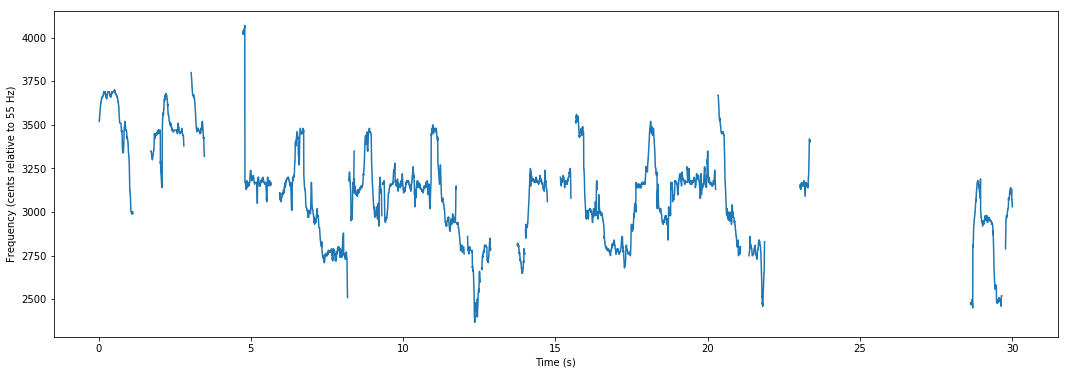

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/cdbb37ee18245800e331528fd781bac388da9254?cid=f6c97a562e044a11bb475c79783b6f81


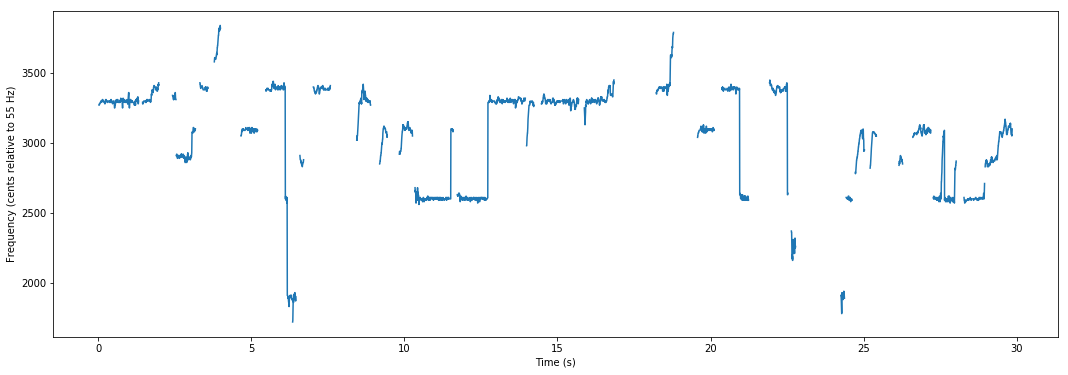

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/57e57e6eb594e55de01b85cea4d470243f6121f5?cid=f6c97a562e044a11bb475c79783b6f81


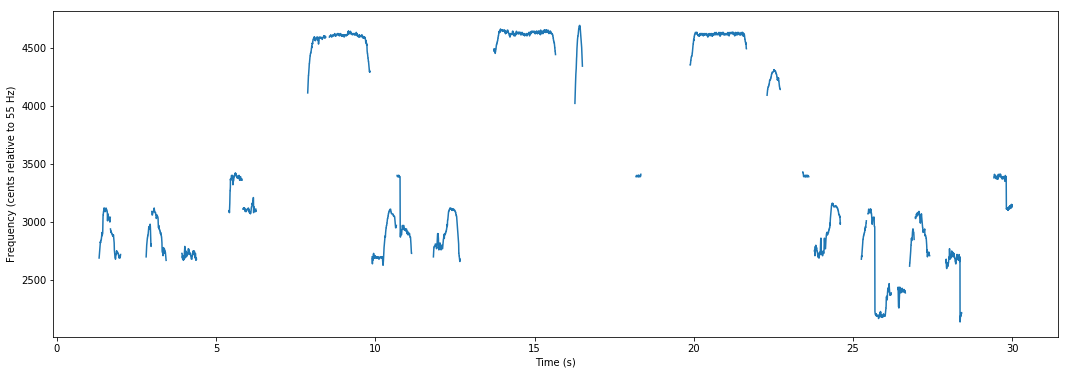

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/37bf226e93591d438dde11e6404e3751a108084f?cid=f6c97a562e044a11bb475c79783b6f81


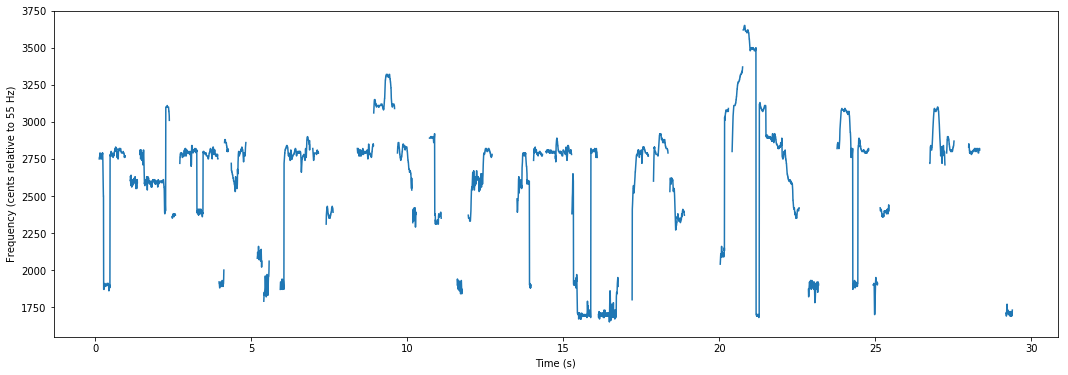

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/043435de75e5889850d1caa8a479d5168ecf5ff3?cid=f6c97a562e044a11bb475c79783b6f81


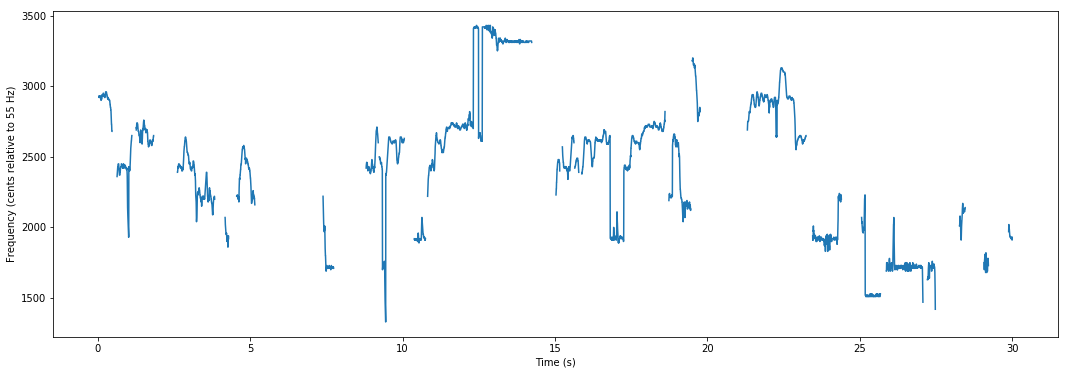

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/5342882884df422c954a1b12dc77750267d2e2bc?cid=f6c97a562e044a11bb475c79783b6f81


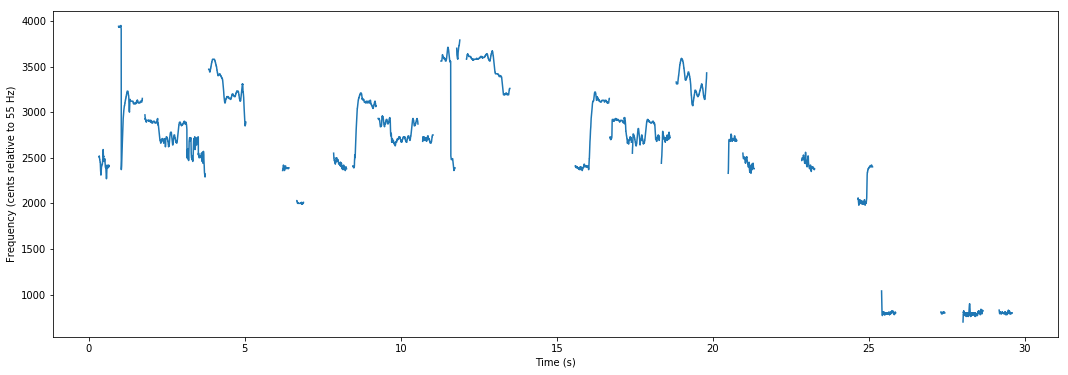

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/c808e35b385571cbda7ccf893c9c568b83a0390d?cid=f6c97a562e044a11bb475c79783b6f81


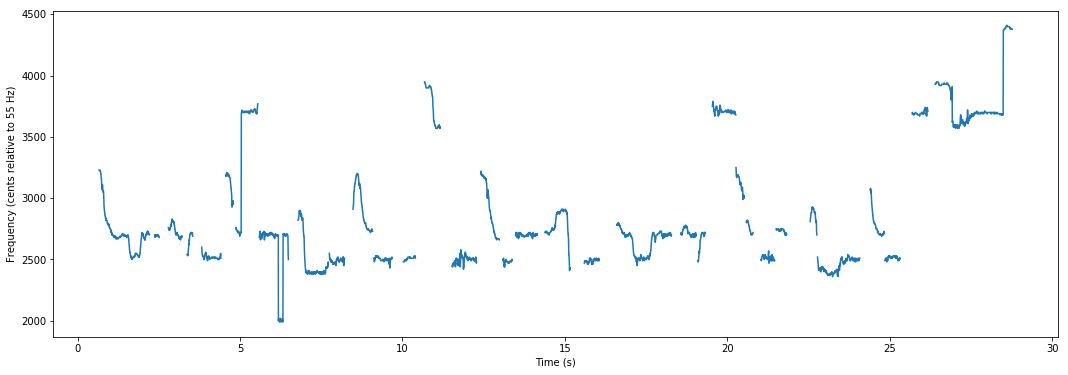

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


None
https://p.scdn.co/mp3-preview/90e41778392f27b6f7dd82db4c90916b3727aa6a?cid=f6c97a562e044a11bb475c79783b6f81


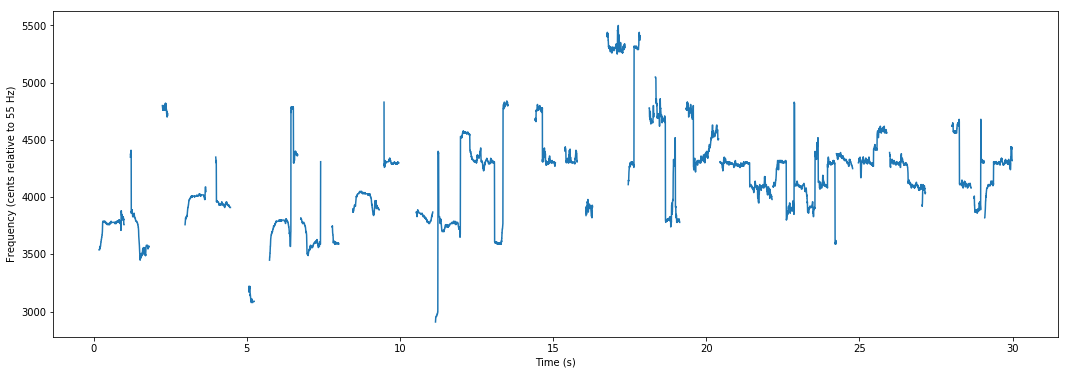

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/097c7b735ceb410943cbd507a6e1dfda272fd8a8?cid=f6c97a562e044a11bb475c79783b6f81


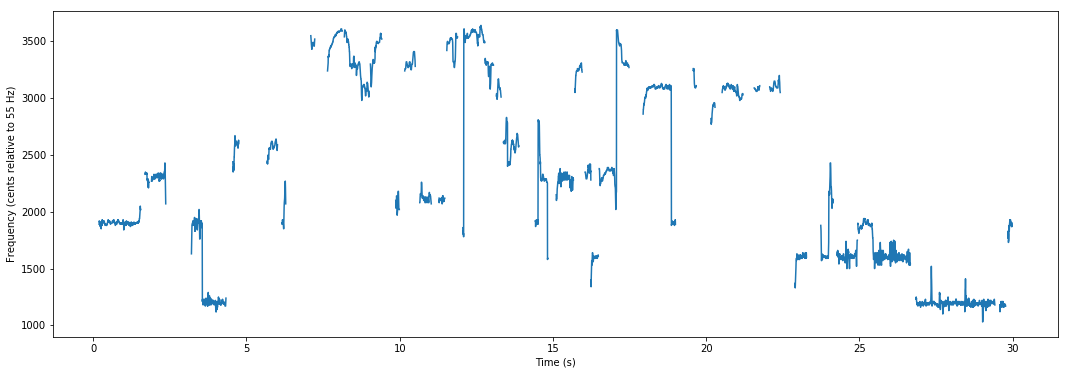

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/3c97985f3736fab6d4abcd2067f346a9b30955fa?cid=f6c97a562e044a11bb475c79783b6f81


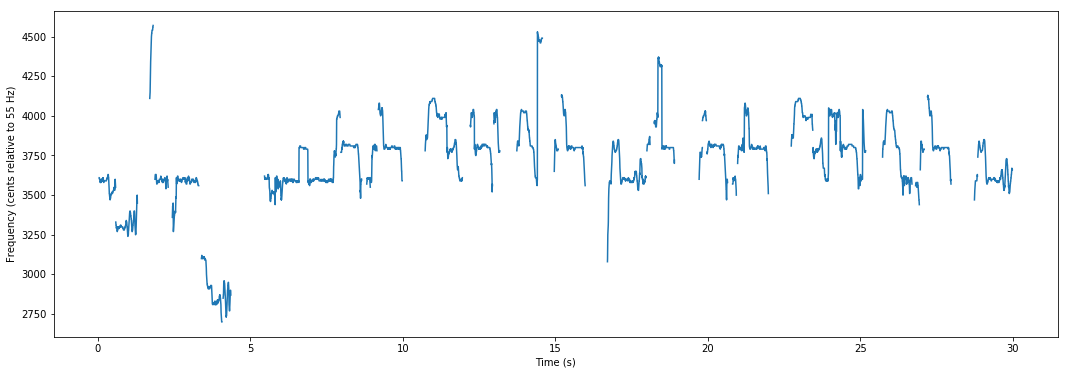

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/d4b8a121add6ac4afbec29670f93d3c56b4dd4d2?cid=f6c97a562e044a11bb475c79783b6f81


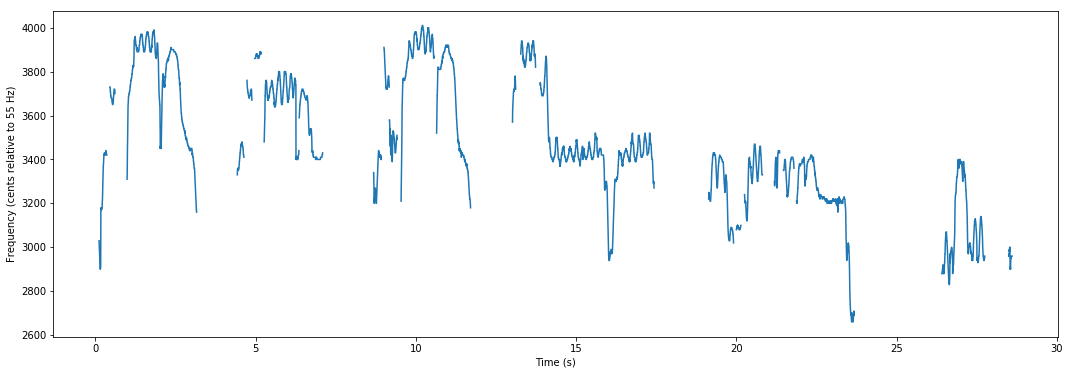

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


None
https://p.scdn.co/mp3-preview/445dba982a0c73334ab598f1a23a4dea70c67c47?cid=f6c97a562e044a11bb475c79783b6f81


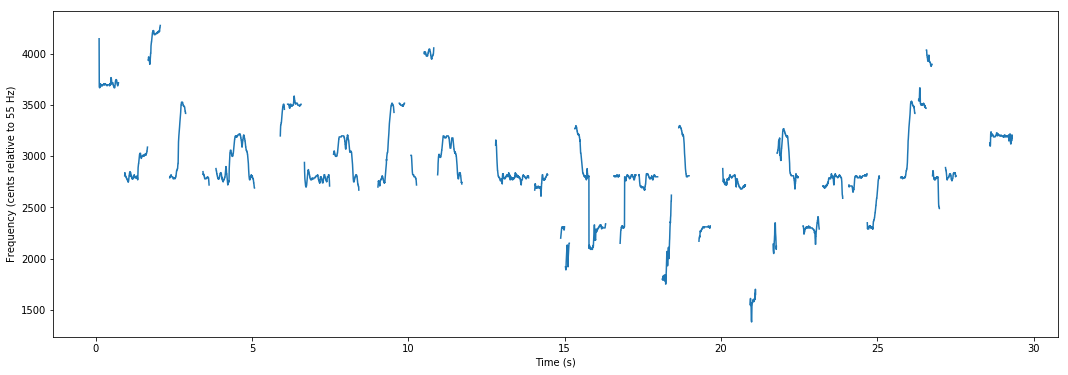

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


None
https://p.scdn.co/mp3-preview/c58f1bc9160754337b858a4eb824a6ac2321041d?cid=f6c97a562e044a11bb475c79783b6f81


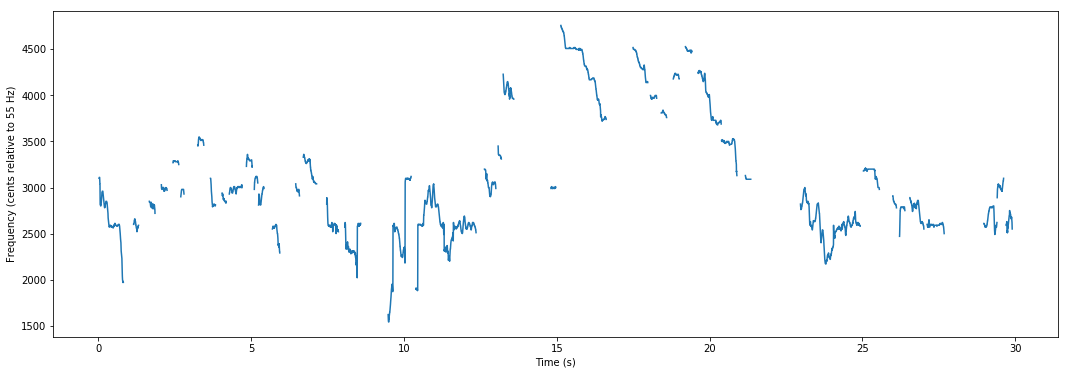

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


None
https://p.scdn.co/mp3-preview/f12c28a584052bea2731e3589644a77165b02f7c?cid=f6c97a562e044a11bb475c79783b6f81


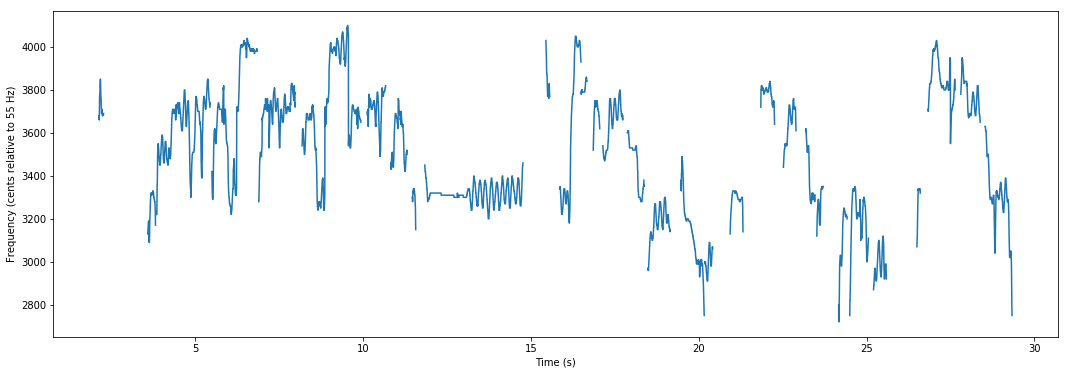

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/498ef064bef20a0690c10fb8067e71bd73411056?cid=f6c97a562e044a11bb475c79783b6f81


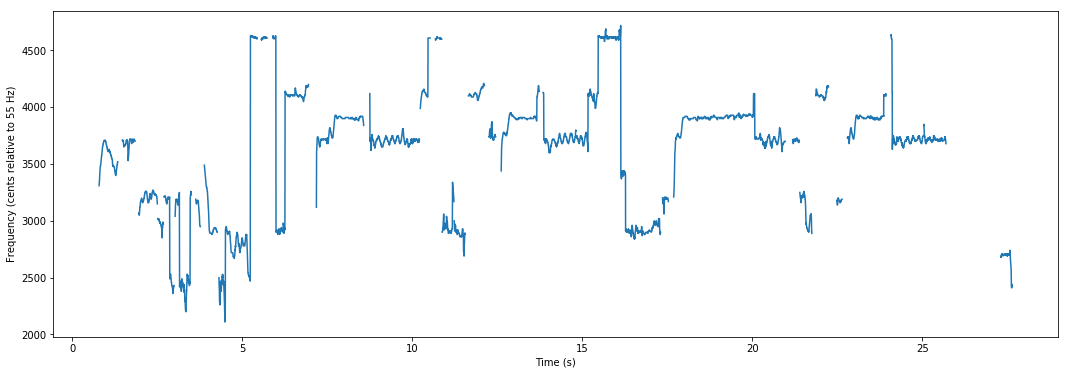

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/f4298433180fb28fcca043815192d22e12821a63?cid=f6c97a562e044a11bb475c79783b6f81


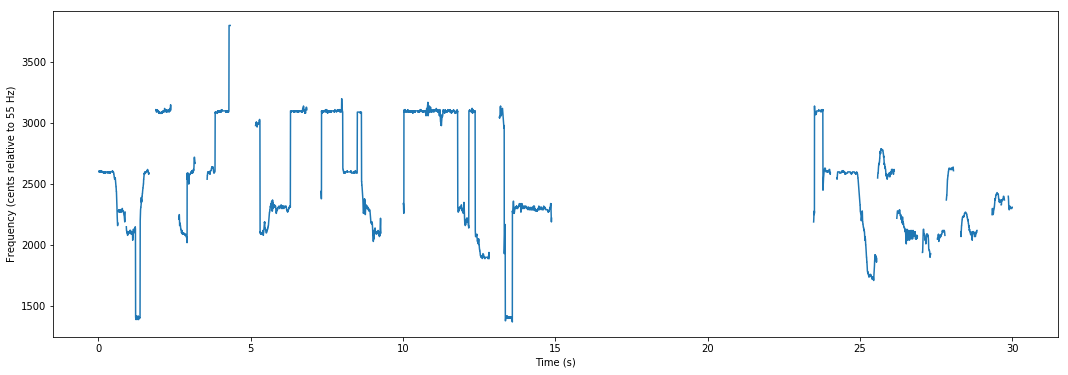

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/b0aace1f8a27b540a9fd96775d7665e3e2b73029?cid=f6c97a562e044a11bb475c79783b6f81


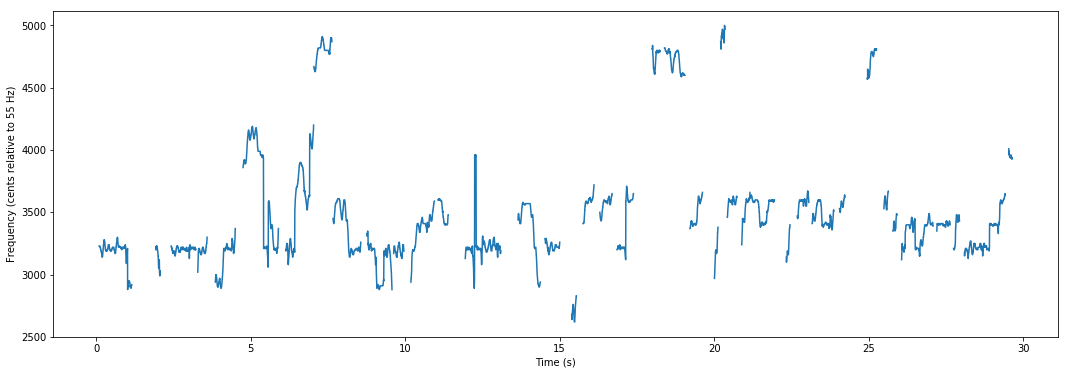

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


None
https://p.scdn.co/mp3-preview/529519c74312d9a940114264e608f8cbf779628a?cid=f6c97a562e044a11bb475c79783b6f81


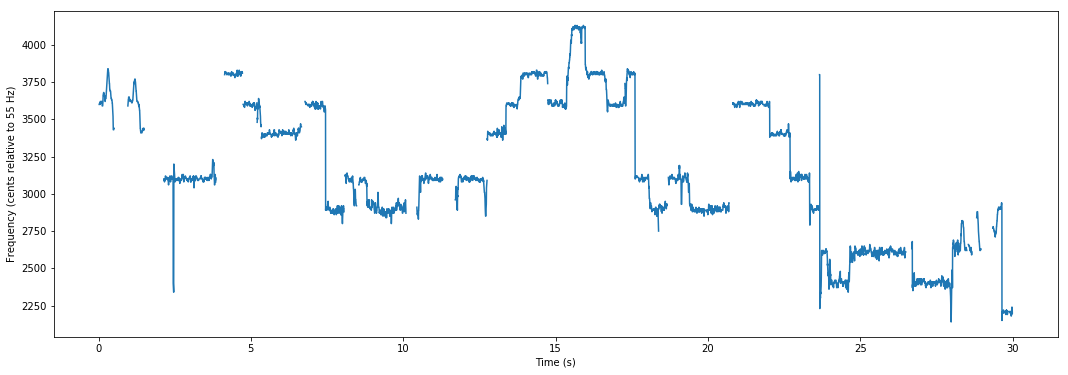

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/8e1ff07117c78984d221597a80148e80eae6e146?cid=f6c97a562e044a11bb475c79783b6f81


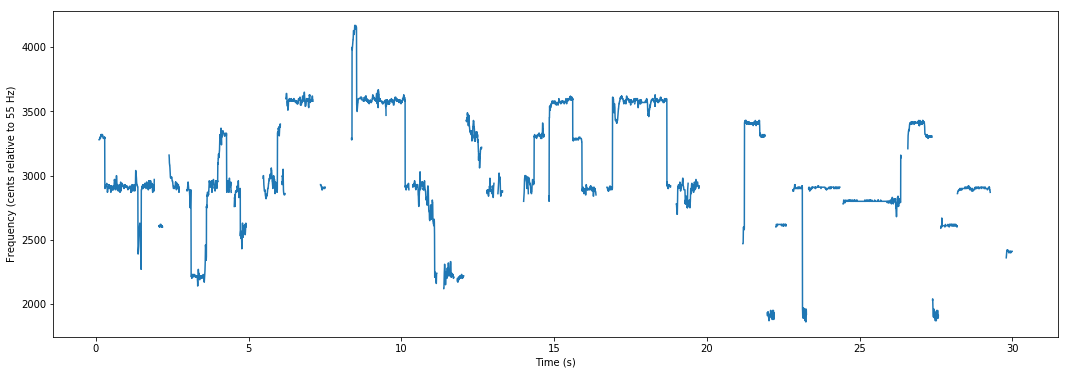

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/2824b10f1392dff3a3c95309a205d6f3e2ea56ad?cid=f6c97a562e044a11bb475c79783b6f81


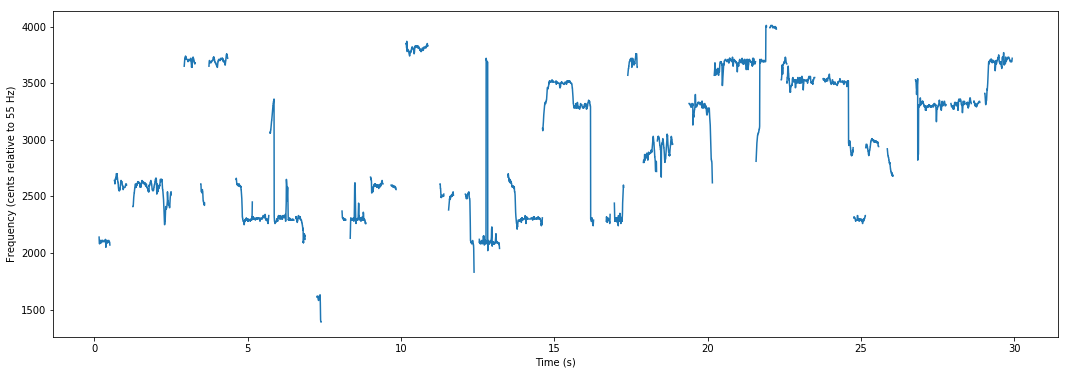

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/c119ca773ef844108da21c4679dc54c007cf0926?cid=f6c97a562e044a11bb475c79783b6f81


/Users/alexkim/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log2


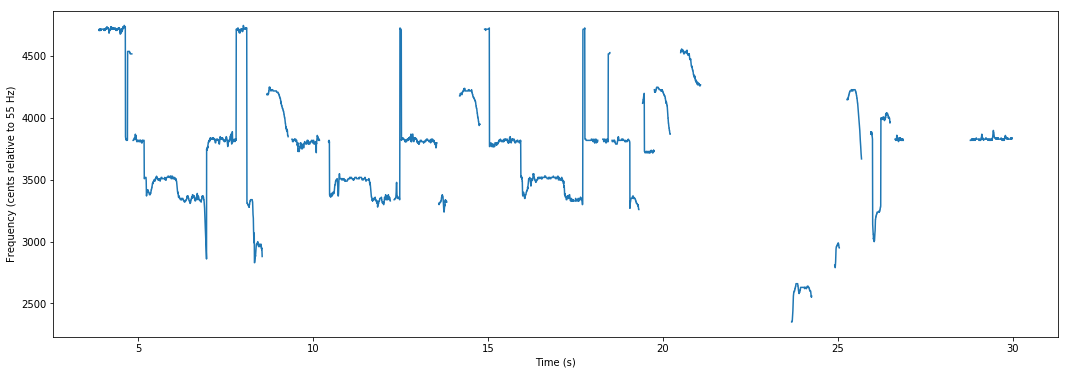

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/a83eedd6b982d4afdc2ceaeb458f471118ad78aa?cid=f6c97a562e044a11bb475c79783b6f81


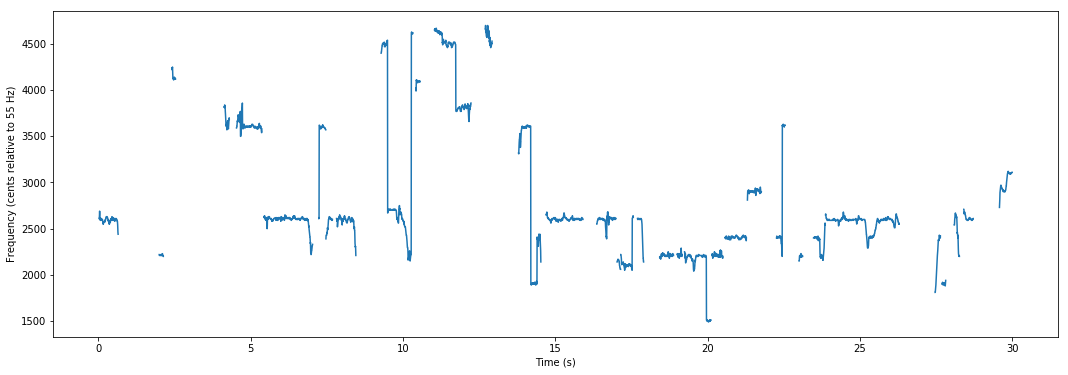

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


None
https://p.scdn.co/mp3-preview/cb51ebbff7000a306fa82db4c8a9e22f353fa930?cid=f6c97a562e044a11bb475c79783b6f81


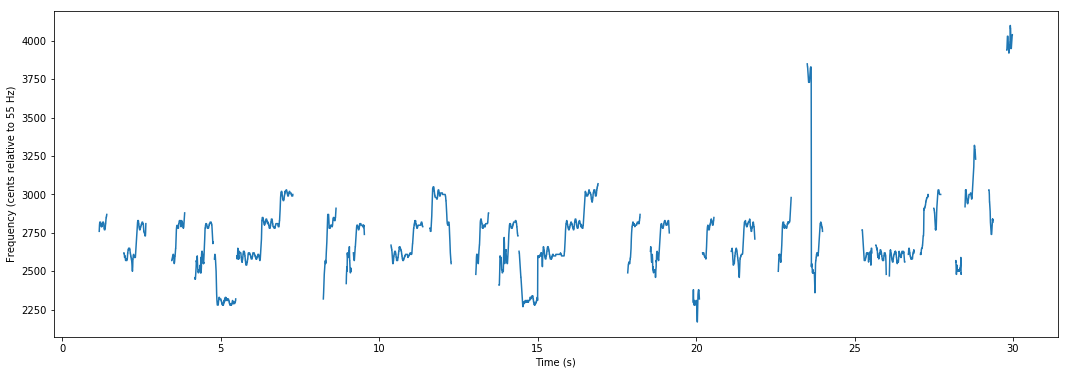

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/3e3a87c95da2861b66d1c4bacb853ecaabbef165?cid=f6c97a562e044a11bb475c79783b6f81


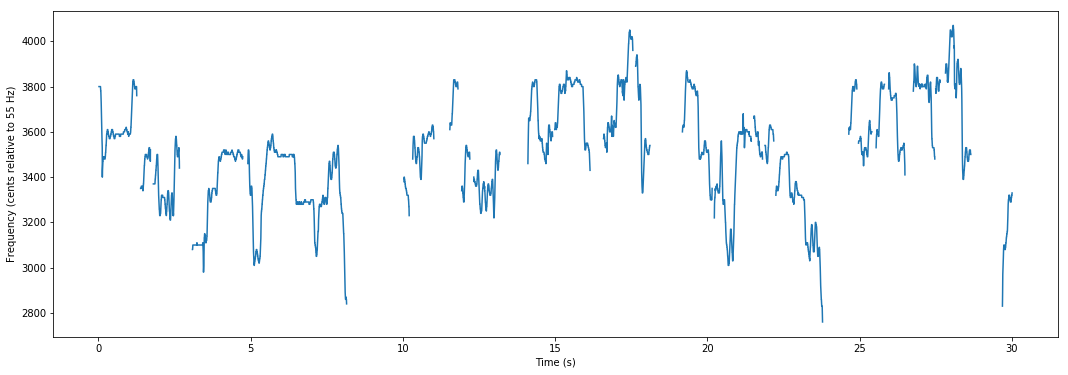

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


None
https://p.scdn.co/mp3-preview/297a4fb327bc2de23d8c1df76dc1af72cab0df31?cid=f6c97a562e044a11bb475c79783b6f81


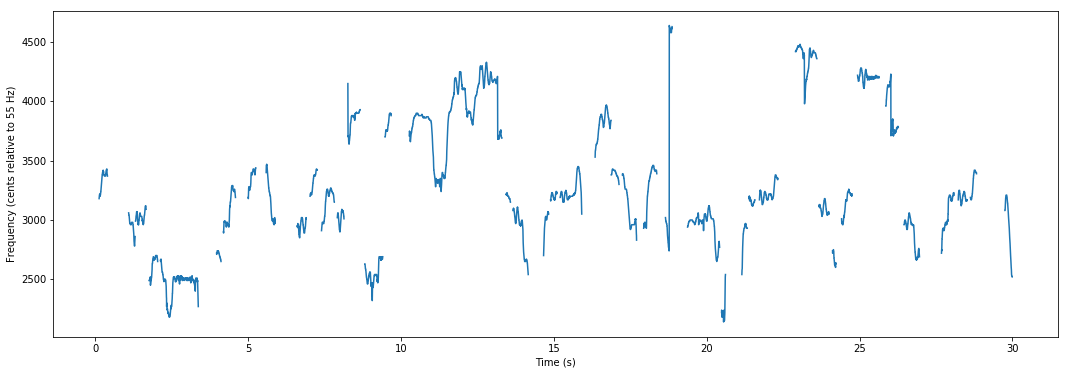

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/814ba0347b23558d7c4477458dbb68ab8b8f4baf?cid=f6c97a562e044a11bb475c79783b6f81


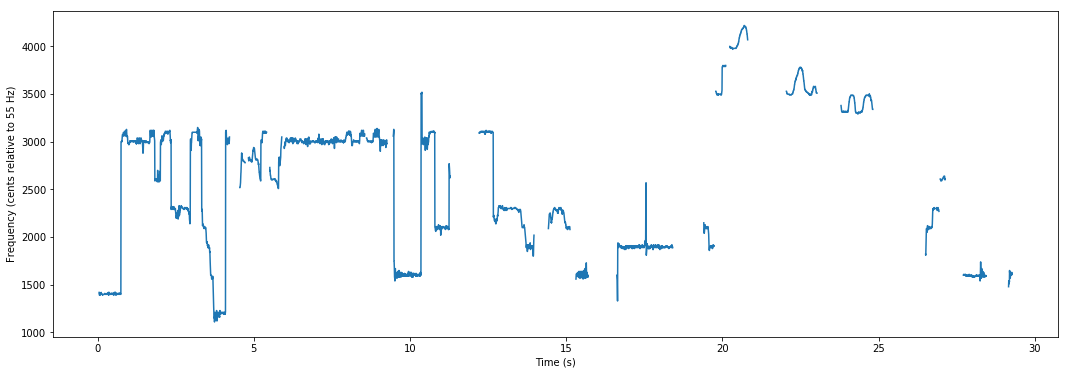

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


None
https://p.scdn.co/mp3-preview/d421a626d2e7bdb323e6ab1b8ebe30c91a3d1064?cid=f6c97a562e044a11bb475c79783b6f81


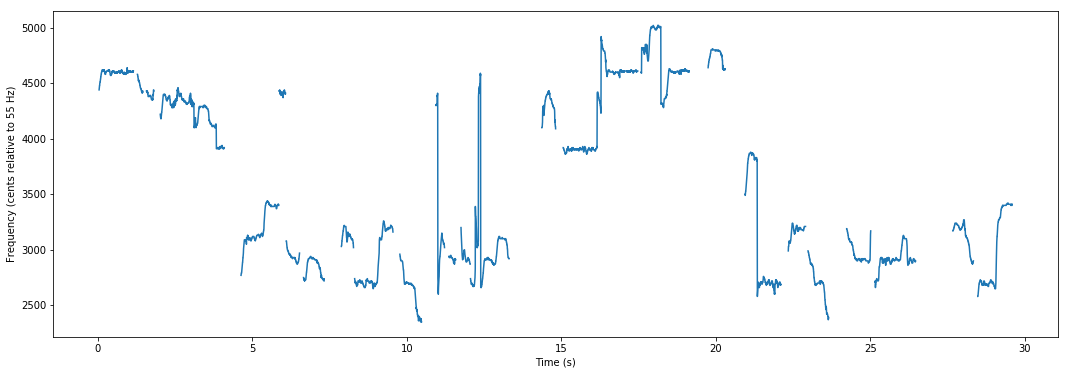

INFO:Loading data...
INFO:Generating wave...
INFO:Saving csv file...
INFO:Saving wav file...
INFO:Saving mixed wav file...


https://p.scdn.co/mp3-preview/7fba47d0806142cb34ad2080a5f139eba915fe05?cid=f6c97a562e044a11bb475c79783b6f81


KeyboardInterrupt: 

In [18]:
for song in songs[:]:
    
    # Get name, uri, preview_url
    track = song['track']
    name = ''.join(e for e in track['name'] if e.isalnum())
    track_uri = track['uri'].split(':')[2]
    #analysis = sp.audio_analysis(track_uri)
    preview_url = track['preview_url']
    
    print(preview_url)
    # If preview url is unavailable, skip song
    if (preview_url == None): continue
    
    
    # Extract Melody and create Melody wav
    timestamps, melody, orig_url = extractMelody(preview_url)
    createMelody(timestamps, melody, orig_url, name)
    

# Final Python File